<a href="https://colab.research.google.com/github/CodeX-Devansh/Breast-Cancer-prediction-using-ResNet-Model/blob/main/Breast_cancer_prediction_using_the_ResNet_model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Breast cancer prediction using ResNet model.**

Epoch 1/100
15/15 [==============================] - 14s 89ms/step - loss: 0.3594 - accuracy: 0.8527 - val_loss: 0.5296 - val_accuracy: 0.8421
Epoch 2/100
15/15 [==============================] - 0s 31ms/step - loss: 0.1859 - accuracy: 0.9253 - val_loss: 0.5106 - val_accuracy: 0.7632
Epoch 3/100
15/15 [==============================] - 0s 33ms/step - loss: 0.1702 - accuracy: 0.9495 - val_loss: 0.4724 - val_accuracy: 0.7719
Epoch 4/100
15/15 [==============================] - 0s 31ms/step - loss: 0.1074 - accuracy: 0.9582 - val_loss: 0.4685 - val_accuracy: 0.7456
Epoch 5/100
15/15 [==============================] - 1s 48ms/step - loss: 0.0927 - accuracy: 0.9736 - val_loss: 0.4604 - val_accuracy: 0.7719
Epoch 6/100
15/15 [==============================] - 1s 57ms/step - loss: 0.0392 - accuracy: 0.9890 - val_loss: 0.3604 - val_accuracy: 0.8246
Epoch 7/100
15/15 [==============================] - 1s 60ms/step - loss: 0.0532 - accuracy: 0.9802 - val_loss: 0.3013 - val_accuracy: 0.8333
Epoch

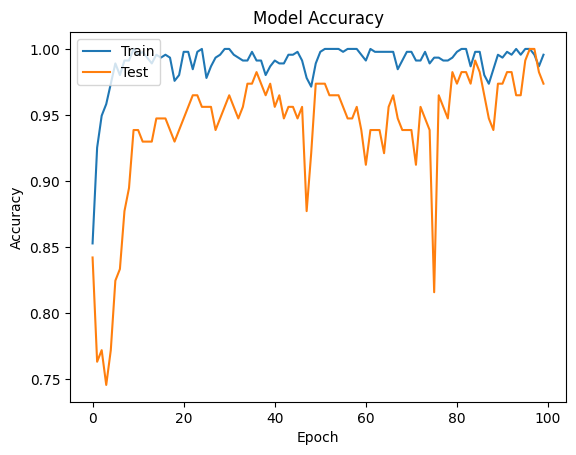

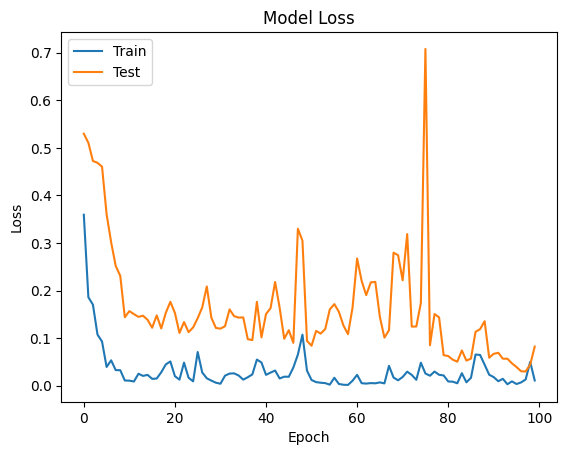

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)

# Split the dataset into features and labels
X = data.iloc[:, 2:].values
y = data.iloc[:, 1].values

# Encode the labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Scale the features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Reshape the data
X_train = X_train.reshape(X_train.shape[0], 30, 1)
X_test = X_test.reshape(X_test.shape[0], 30, 1)

# Build the model
def resnet_block(inputs, num_filters=16, kernel_size=3, strides=1, activation='relu'):
    x = keras.layers.Conv1D(num_filters, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
    x = keras.layers.BatchNormalization()(x)
    if activation:
        x = keras.layers.Activation(activation)(x)
    return x

def resnet_v1(input_shape, depth, num_classes=1):
    if (depth - 2) % 6 != 0:
        raise ValueError('Depth must be 6n + 2 (e.g. 20, 32, 44).')
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = keras.layers.Input(shape=input_shape)
    x = resnet_block(inputs)
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:
                strides = 2
            y = resnet_block(x, num_filters=num_filters, strides=strides)
            y = resnet_block(y, num_filters=num_filters, activation=None)
            if stack > 0 and res_block == 0:
                x = resnet_block(x, num_filters=num_filters, kernel_size=1, strides=strides, activation=None)
            x = keras.layers.add([x, y])
            x = keras.layers.Activation('relu')(x)
        num_filters *= 2

    x = keras.layers.GlobalAveragePooling1D()(x)
    outputs = keras.layers.Dense(num_classes, activation='sigmoid')(x)

    model = keras.models.Model(inputs=inputs, outputs=outputs)
    return model

model = resnet_v1(input_shape=(30, 1), depth=20)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print('Test accuracy:', test_acc)

# Make predictions
predictions = model.predict(X_test)
y_pred = np.round(predictions)

# Print the predicted cancer type and its probability
for i in range(len(y_pred)):
    if y_pred[i][0] == 0:
        print("Sample", i+1, "is predicted to have malignant cancer with a probability of", round((1 - predictions[i][0]) * 100, 2), "%")
    else:
        print("Sample", i+1, "is predicted to have benign cancer with a probability of", round(predictions[i][0] * 100, 2), "%")

# Plot the training and testing accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot the training and testing loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
